In [1]:
dataset = "merfish"


# Setup


In [13]:
import bento as bt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
# import seaborn.objects as so
# from hmr import Reloader
from scipy.stats import zscore
from statannotations.Annotator import Annotator

sc.set_figure_params(dpi=80)
# bento = Reloader(bento)


# Quality Control


In [4]:
adata = bento.datasets.load_dataset(dataset)


Remove cells without nuclei


In [5]:
adata = adata[adata.obs["nucleus_shape"] != None]


Check QC distributions


In [8]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
bt.tl.obs_stats(adata)

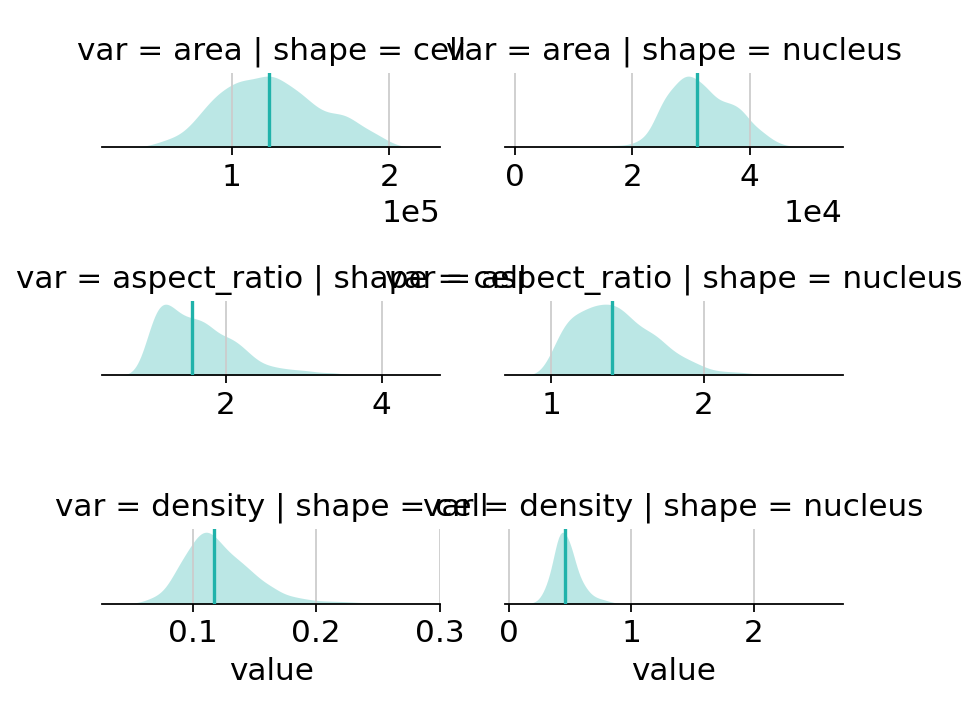

In [14]:
bt.pl.obs_stats(adata)

## Filter out poor quality cells.

- remove cells with extremely small nuclei


Perform filtering


In [9]:
adata = adata[
    (adata.obs["nucleus_density"] <= 1000) & (adata.obs["nucleus_area"] >= 5000)
]
adata.shape


(1006, 135)

Filter out inconsistently expressed genes

- at least 20 in 10% of cells
- this is necessary to reduce tensor heterogeneity -> ensure low rank decompositions -> improve interpretability


In [10]:
min_count = 20
min_cells = int(0.1 * adata.n_obs)
valid_genes = (adata.to_df() >= min_count).sum()
valid_genes = valid_genes[valid_genes >= min_cells].index.tolist()


In [11]:
adata = adata[:, valid_genes]
bt.sync(adata)


In [12]:
adata.shape


(1006, 120)

Check QC distributions


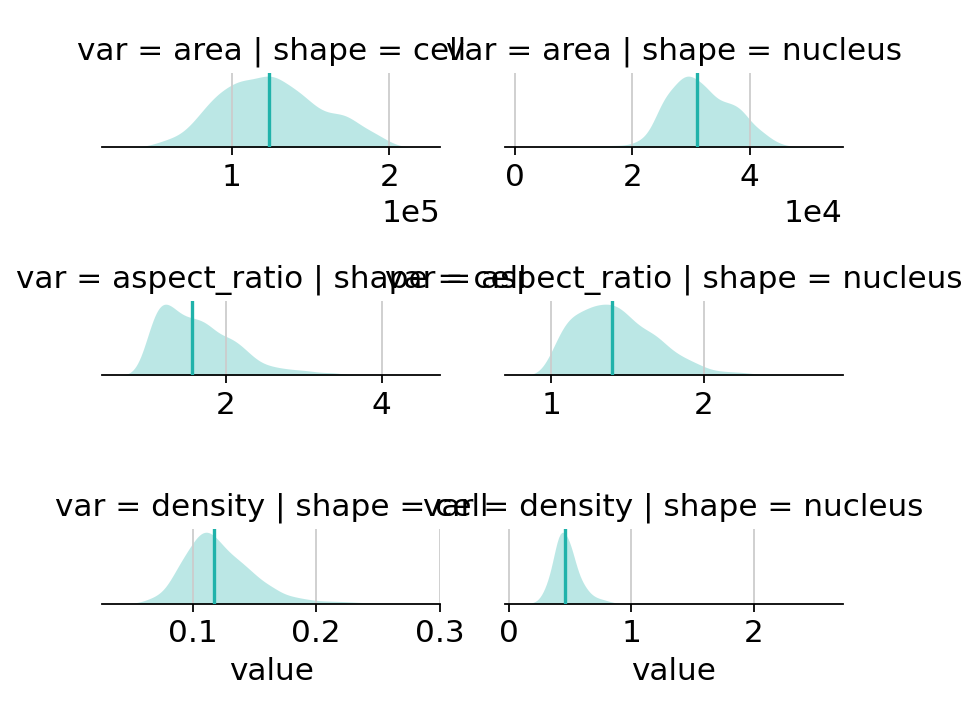

In [15]:
bento.pl.obs_stats(adata)


In [16]:
adata.obs["cytoplasm_shape"] = bento.geo.get_shape(
    adata, "cell_shape"
) - bento.geo.get_shape(adata, "nucleus_shape")

adata.uns["points"]["cytoplasm"] = adata.uns["points"]["nucleus"] != -1


In [17]:
shapes = ["nucleus_shape", "cytoplasm_shape"]
bento.tl.coloc_quotient(adata, shapes=shapes, radius=20)


nucleus_shape:   0%|          | 0/1006 [00:00<?, ?it/s]

cytoplasm_shape:   0%|          | 0/1006 [00:00<?, ?it/s]

In [19]:
ranks = range(2, 11)
ranks=[4]
bt.tl.colocation(adata, ranks, iterations=2)


Preparing tensor...
(2, 1006, 14400)
:running: Decomposing tensor...


Device cpu:   0%|          | 0/1 [00:00<?, ?it/s]

:heavy_check_mark: Done.


# Compare clq distributions


In [20]:
cyto = adata.uns["clq"]["cytoplasm_shape"]
cyto["compartment"] = "cytoplasm"

nuc = adata.uns["clq"]["nucleus_shape"]
nuc["compartment"] = "nucleus"

clq = pd.concat([cyto, nuc], ignore_index=True)

clq["self"] = clq["gene"] == clq["neighbor"]
clq["log(clq + 1)"] = np.log2(clq["clq"] + 1)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

nucleus_False vs. nucleus_True: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=8.568e+10
cytoplasm_False vs. cytoplasm_True: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=1.684e+11
cytoplasm_False vs. nucleus_False: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.979e-01 U_stat=3.853e+13
cytoplasm_True vs. nucleus_True: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=5.761e+09


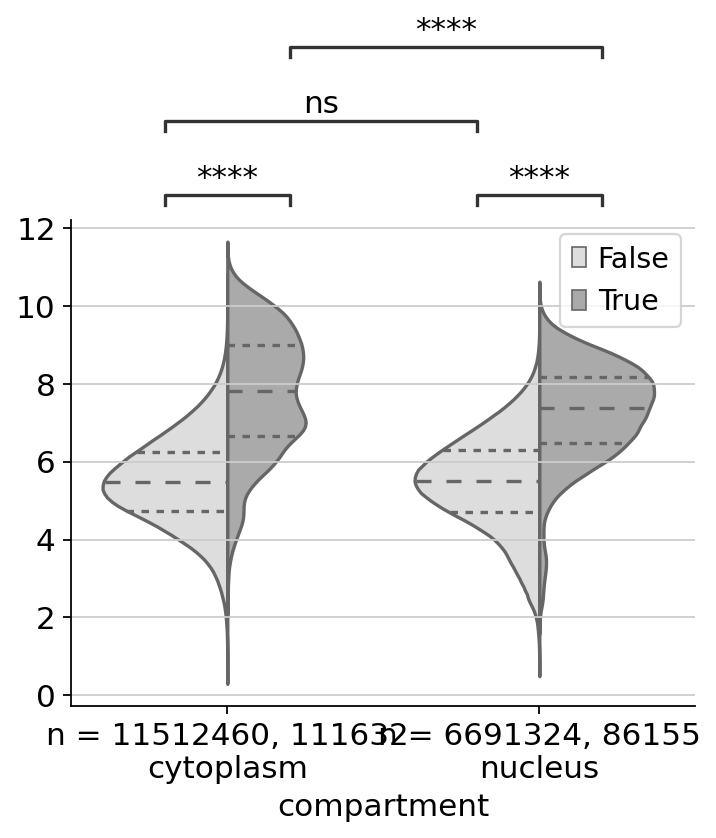

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.violinplot(
    data=clq,
    x="compartment",
    y="log(clq + 1)",
    hue="self",
    split=True,
    inner="quartiles",
    cut=0,
    palette=sns.color_palette(["#DDD", "#AAA"]),
    ax=ax,
)

n_samples = clq.groupby(["compartment", "self"]).size()

xticklabels = []
for compartment, row in zip(
    clq["compartment"].unique(), n_samples.values.reshape(2, 2)
):
    cat_ns = ", ".join([str(v) for v in row])
    xticklabels.append("n = " + cat_ns + f"\n{compartment}")

ax.set_xticklabels(xticklabels)
ax.set_ylabel(None)
ax.legend()
sns.despine()

# Pairwise tests of significance (with correction)
pairs = [
    (("cytoplasm", False), ("cytoplasm", True)),
    (("nucleus", False), ("nucleus", True)),
    (("cytoplasm", False), ("nucleus", False)),
    (("cytoplasm", True), ("nucleus", True)),
]
annotator = Annotator(
    ax, pairs, data=clq, x="compartment", y="log(clq + 1)", hue="self"
)
annotator.configure(
    test="Mann-Whitney",
    comparisons_correction="Benjamini-Hochberg",
    text_format="star",
    loc="outside",
)
annotator.apply_and_annotate()

fname = f"/home/ckmah/projects/bento-manuscript/figures/{dataset}_clq_dists.svg"
rc = {"svg.fonttype": "none", "font.family": "Arial"}
with plt.rc_context(rc):
    plt.savefig(fname, dpi=400)


Saved to /home/ckmah/projects/bento-manuscript/figures/merfish_coloc4.svg


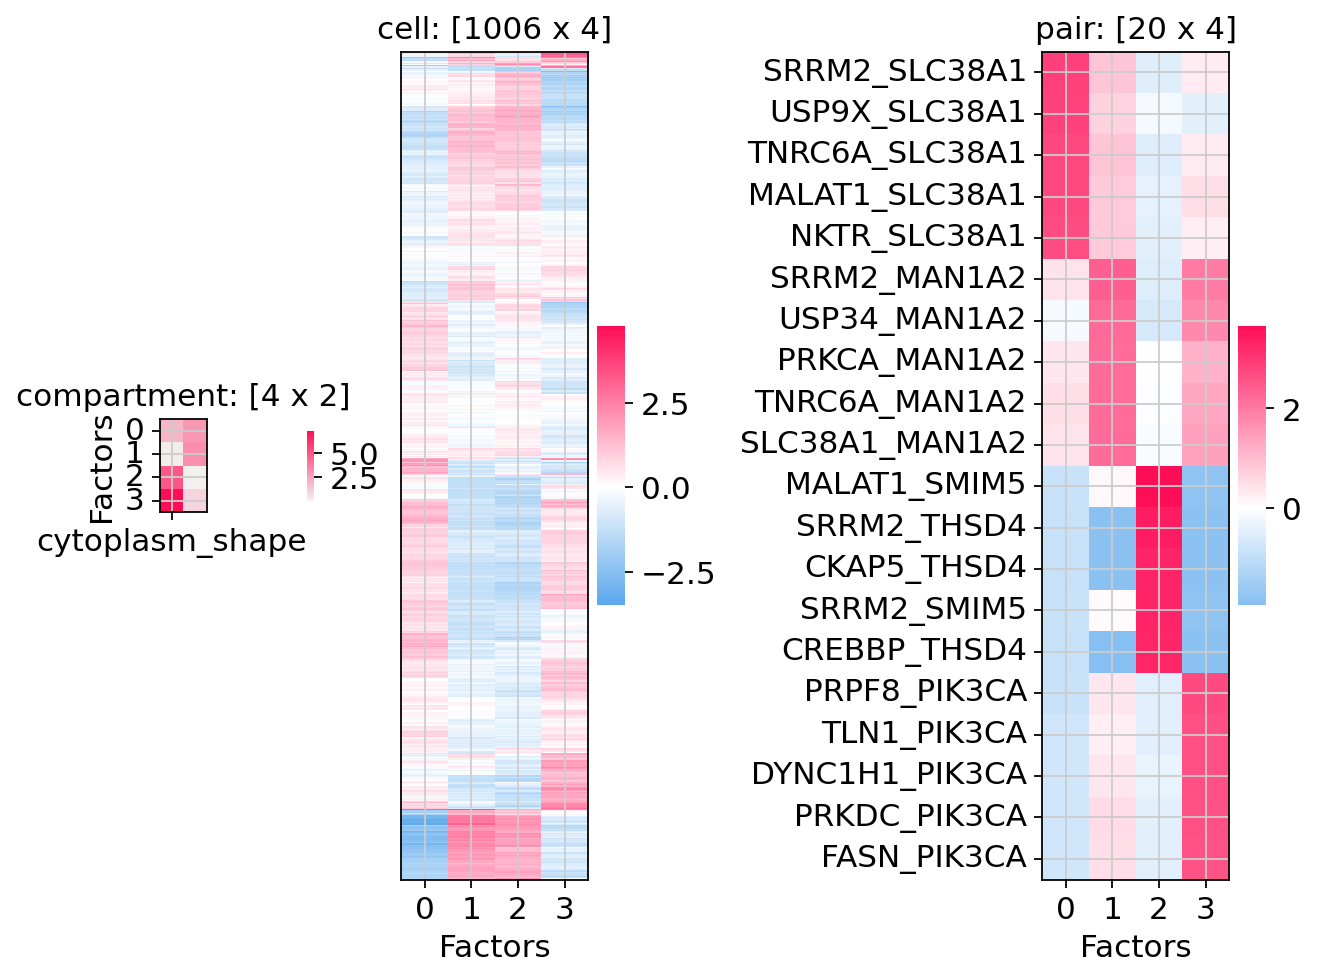

In [23]:
for r in [4]:
    bt.pl.colocation(
        adata,
        r,
        # n_top=[None, None, 5],
        z_score=[False, True, True],
        fname=f"/home/ckmah/projects/bento-manuscript/figures/{dataset}_coloc{r}.svg",
    )


---

In [ ]:
bento.io.write_h5ad(
    adata,
    f"/cellar/users/ckmah/spatial/data/{dataset}_clq_factors.h5ad",
)


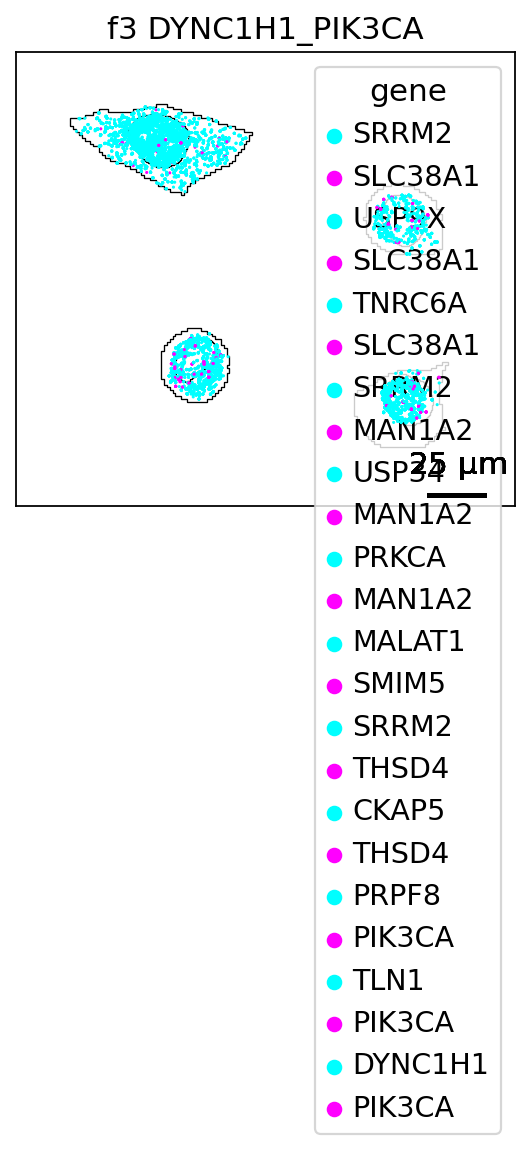

In [26]:
def sig_samples(data, r, n_pairs=3, n_cells=3):

    cell_sig = pd.DataFrame(
        data.uns["factors"][r][1], index=data.uns["tensor_labels"]["cell"]
    )
    pair_sig = pd.DataFrame(
        data.uns["factors"][r][2], index=data.uns["tensor_labels"]["pair"]
    )
    pair_sig["self"] = [
        pair.split("_")[0] == pair.split("_")[1]
        for pair in pair_sig.index.tolist()
    ]
    pair_sig = pair_sig[~pair_sig["self"]]

    for f in cell_sig.columns:

        top_cells = cell_sig.sort_values(f, ascending=False).index.tolist()[
            :n_cells
        ]

        top_pairs = pair_sig.sort_values(f, ascending=False).index.tolist()[
            :n_pairs
        ]

        for i, pair in enumerate(top_pairs):
            genes = pair.split("_")

            bt.pl.points(
                data[top_cells, genes],
                hue="gene",
                hue_order=genes,
                palette=["cyan", "magenta"],
                # point_kws=dict(
                #     s=8,
                #     marker=",",
                #     # alpha=0.6,
                #     # lw=1
                # ),
                # fname=f"{figdir}/{dataset}/f{f}_{pair}.svg",
                title=f"f{f} {pair}"
            )
        # break



sig_samples(adata, r=4, n_cells=2, n_pairs=3)

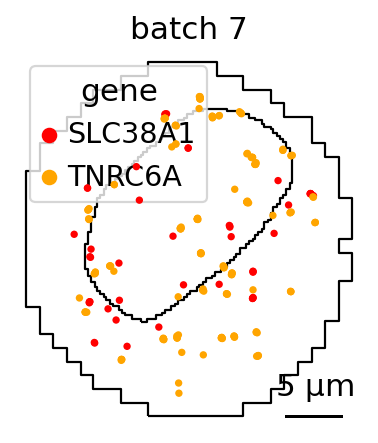

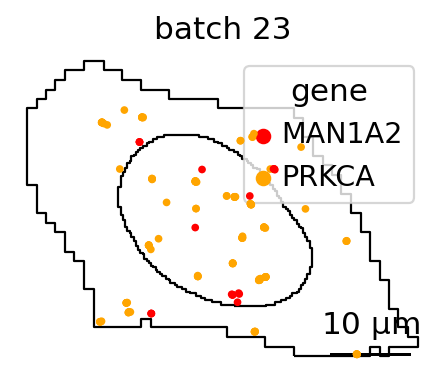

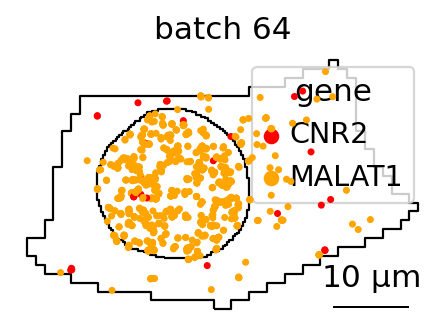

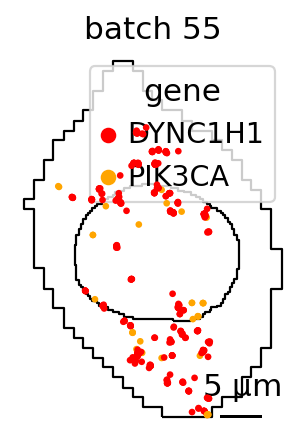

In [42]:
%matplotlib inline
factors = [0, 1, 2, 3]
cells = ["10-7", "5-23", "29-64", "39-55"]
genes = [
    ["TNRC6A", "SLC38A1"],
    ["PRKCA", "MAN1A2"],
    ["MALAT1", "CNR2"],
    ["DYNC1H1", "PIK3CA"],
]
sizes = [11, 12, 10, 9]
for f, cell, pair, s in zip(factors, cells, genes, sizes):
    plt.figure(figsize=(3,3))
    bt.pl.points(
        adata[cell, pair],
        hue="gene",
        palette=["red", "orange"],
        shapes_kws=dict(lw=1),
        s=s,
        frame_visible=False,
        title=""
        # point_kws=dict(s=s),
        # fname=f"{figdir}/merfish/f{f}_{'_'.join(pair)}.svg",
    )
    plt.tight_layout()
    # break

In [46]:
pair

['TNRC6A', 'SLC38A1']

todo groupby compartment

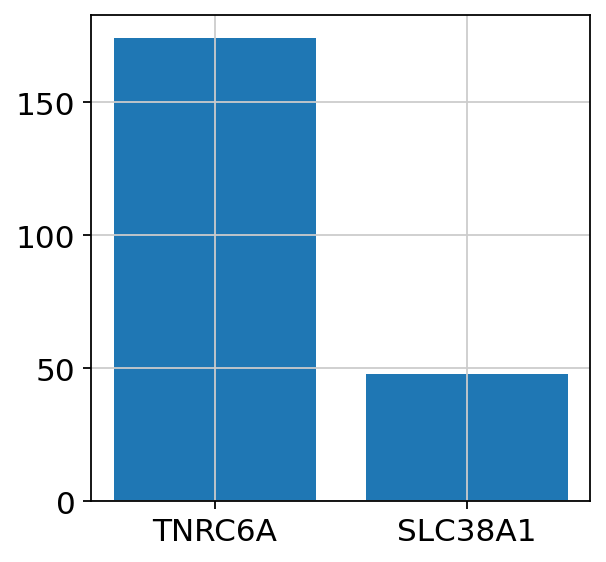

In [51]:
for f, cell, pair, s in zip(factors, cells, genes, sizes):
    plt.bar(pair, adata[cell, pair].X.toarray().flatten())
    break